# Model training for clustering pre-snap movements

## Importing the libraries

In [71]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples
from tensorflow import keras
import keras_tuner as kt
import matplotlib.pyplot as plt
import random

## Loading the dataset

First, let's load our preprocessed dataset.

In [15]:
track_preprocessed = pd.read_csv('data/track_preprocessed.csv')

## Modifying direction and orientation data

We have two features that have values in degrees from 0 to 360, they are 'dir' and 'o'. The problem with this is that degrees are circular. For example, value 300 is closer to 0 than to 200. To take this into account let's use convert degrees to sin and cos pairs. This will ensure that values close to each other spatially are also close in the transformed feature space.

In [ ]:
# Convert degrees to radians
track_preprocessed_sin_cos = track_preprocessed
track_preprocessed_sin_cos['dir_rad'] = np.deg2rad(track_preprocessed['dir'])
track_preprocessed_sin_cos['o_rad'] = np.deg2rad(track_preprocessed['o'])

In [19]:
# Compute sin and cos
track_preprocessed_sin_cos['sin_dir'] = np.sin(track_preprocessed_sin_cos['dir_rad'])
track_preprocessed_sin_cos['cos_dir'] = np.cos(track_preprocessed_sin_cos['dir_rad'])
track_preprocessed_sin_cos['sin_o'] = np.sin(track_preprocessed_sin_cos['o_rad'])
track_preprocessed_sin_cos['cos_o'] = np.cos(track_preprocessed_sin_cos['o_rad'])

In [20]:
# Drop unnecessary columns
track_preprocessed_sin_cos.drop(['dir', 'o', 'dir_rad', 'o_rad'], axis=1, inplace=True)

## Scaling the data

We need to prepare our data for model training. Let's first explore how the data looks like.

In [21]:
track_preprocessed_sin_cos.describe()

,gameId,playId,nflId,frameId,jerseyNumber,x,y,s,a,dis,sin_dir,cos_dir,sin_o,cos_o
count,1.935150e+05,193515.000000,193515.000000,193515.000000,193515.000000,193515.000000,193515.000000,193515.000000,193515.000000,193515.000000,193515.000000,193515.000000,193515.000000,193515.000000
mean,2.022099e+09,1810.303827,48095.865861,87.798672,34.654817,-2.560307,-0.100292,1.840526,1.273277,0.183987,-0.058224,-0.003223,0.650092,0.004339
std,6.109477e+03,1144.594837,4561.215261,32.568068,32.226856,1.155717,8.482461,2.210957,1.483284,0.218182,0.504333,0.861541,0.441455,0.618452
min,2.022091e+09,55.000000,30842.000000,1.000000,1.000000,-10.029998,-23.959999,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,2.022092e+09,800.000000,44881.000000,68.000000,11.000000,-2.780001,-7.230001,0.030000,0.030000,0.010000,-0.330514,-0.965564,0.348081,-0.431299
50%,2.022101e+09,1683.000000,47836.000000,87.000000,17.000000,-2.330001,-0.090000,0.490000,0.680000,0.050000,-0.064184,-0.010995,0.896409,0.008028
75%,2.022102e+09,2757.000000,52608.000000,106.000000,81.000000,-1.950000,7.130000,3.550000,2.140000,0.350000,0.166597,0.964695,0.986170,0.437508
max,2.022111e+09,4686.000000,55157.000000,695.000000,89.000000,5.250002,23.370000,8.640000,12.040000,1.050000,1.000000,1.000000,1.000000,1.000000


Of course, the data is not scaled yet. Let's scale it using Standard Scaler.

In [24]:
columns_to_scale = ['x', 'y', 's', 'a', 'dis', 'sin_o', 'cos_o', 'sin_dir', 'cos_dir'] # Define columns to be sclaed

In [25]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the feature data and transform it
track_preprocessed_scaled = track_preprocessed_sin_cos
track_preprocessed_scaled[columns_to_scale] = scaler.fit_transform(track_preprocessed_sin_cos[columns_to_scale])

Let's confirm that the data is scaled now.

In [26]:
track_preprocessed_scaled.describe()

,gameId,playId,nflId,frameId,jerseyNumber,x,y,s,a,dis,sin_dir,cos_dir,sin_o,cos_o
count,1.935150e+05,193515.000000,193515.000000,193515.000000,193515.000000,1.935150e+05,1.935150e+05,1.935150e+05,1.935150e+05,1.935150e+05,1.935150e+05,1.935150e+05,1.935150e+05,1.935150e+05
mean,2.022099e+09,1810.303827,48095.865861,87.798672,34.654817,-8.459760e-17,8.224767e-18,-5.022983e-17,-1.528558e-16,8.591944e-17,2.834607e-17,1.879947e-17,2.069410e-16,2.349933e-17
std,6.109477e+03,1144.594837,4561.215261,32.568068,32.226856,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,2.022091e+09,55.000000,30842.000000,1.000000,1.000000,-6.463272e+00,-2.812836e+00,-8.324589e-01,-8.584196e-01,-8.432727e-01,-1.867374e+00,-1.156973e+00,-3.737856e+00,-1.623961e+00
25%,2.022092e+09,800.000000,44881.000000,68.000000,11.000000,-1.900938e-01,-8.405258e-01,-8.188900e-01,-8.381942e-01,-7.974394e-01,-5.399035e-01,-1.117002e+00,-6.841262e-01,-7.044016e-01
50%,2.022101e+09,1683.000000,47836.000000,87.000000,17.000000,1.992761e-01,1.213350e-03,-6.108348e-01,-3.999763e-01,-6.141059e-01,-1.181786e-02,-9.021155e-03,5.579688e-01,5.966192e-03
75%,2.022102e+09,2757.000000,52608.000000,106.000000,81.000000,5.280784e-01,8.523836e-01,7.731848e-01,5.843285e-01,7.608949e-01,4.457788e-01,1.123477e+00,7.612993e-01,7.004114e-01
max,2.022111e+09,4686.000000,55157.000000,695.000000,89.000000,6.757997e+00,2.766927e+00,3.075361e+00,7.258724e+00,3.969230e+00,2.098269e+00,1.164455e+00,7.926272e-01,1.609930e+00


We can go on now, but let's scale the data a bit more. Instead of giving the same weight to all of the features that we are planning to use, we will multiply some of them by scaling factor to give them weight. We will do it to speed and acceleration values, since we are mostly focused on the spatial trajectories, but removing speed and acceleartion completely also doesn't seem as a good idea. So we will still keep this feature, but will restrict its influence on training.

In [27]:
track_preprocessed_scaled['s'] *= 0.5
track_preprocessed_scaled['a'] *= 0.5

## Create sequences of coordinates

The model we will use is LSTM encoder-decoder, so we need our data in sequences format.

In [29]:
# Sort data by frameId and group
track_preprocessed_sorted = track_preprocessed_scaled.sort_values(by=['gameId', 'playId', 'nflId', 'frameId'])
track_preprocessed_grouped = track_preprocessed_sorted.groupby(['gameId', 'playId', 'nflId'])

In [30]:
sequences = [] # array of sequences
labels = []  # array for labels

for (groupId, playId, nflId), group in track_preprocessed_grouped:
    # We will keep only following values
    seq = group[['x', 'y', 's', 'a', 'sin_dir', 'cos_dir']].values  # shape (T, 6)
    
    sequences.append(seq)
    labels.append((groupId, playId, nflId))

We also created 'labels' array that stores ids for every sequence now. Later we will add there cluster labels.

Now, we have array of sequences. The problem is that we can have sequences of different length there. We know from preprocessing step that max length for sequence is 50 frames. So let's take sequences that are shorter than 50 frames and pad them with the first frame in the beginning. This will ensure that all the sequences have length 50.

In [31]:
padded_sequences = []

for seq in sequences:
    T = len(seq)

    padding_value = seq[0]
    
    padded = np.full((50, 6), padding_value)

    padded[50 - T:] = seq  # place sequnce at the end
    padded_sequences.append(padded)

padded_sequences = np.array(padded_sequences)

Let's confirm that every sequence has 50 frames

In [32]:
padded_sequences.shape

(4372, 50, 6)

Yes, we've got 4372 sequences, each of length 50 and each frame has 6 features. We can move on to model training now.

## Splitting the data into training and test sets

Before building the model, we will need to split the dataset into train and test sets.

In [33]:
X = padded_sequences
Y = padded_sequences # Targets are same as inputs in our case

In [35]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42) # Using 10% of data for test set

## Building Encoder-Decoder model

We fisrt need to train Encoder-Decoder model in order to be able to get a vector representing sequence, which we can then use for clustering. Let's create a function to build the model.

In [37]:
def build_model(hp):

    # Hyperparameters choice
    units = hp.Choice('units', [16, 32])
    lr = hp.Choice('lr', [1e-3, 1e-5])
    dropout = hp.Float('dropout', 0.0, 0.5, step=0.1)

    # Define the input layer with shape (50, 6)
    encoder_inputs = keras.Input(shape=(50, 6), name="encoder_input")

    # Define the LSTM layer for the encoder
    encoder_lstm = keras.layers.LSTM(
        units,
        return_sequences=False,
        name="encoder_lstm",
        dropout=dropout,          
        recurrent_dropout=dropout
    )

    # Pass the encoder inputs through the encoder LSTM
    encoder_output = encoder_lstm(encoder_inputs)

    # Repeat the encoder output to match the sequence length for the decoder
    decoder_inputs = keras.layers.RepeatVector(50)(encoder_output)

    # Define the LSTM layer for the decoder
    decoder_lstm = keras.layers.LSTM(
        units,                   
        return_sequences=True,
        name="decoder_lstm",
        dropout=dropout,          
        recurrent_dropout=dropout 
    )

    # Pass the repeated vector through the decoder LSTM to generate the output sequence
    decoder_output_sequence = decoder_lstm(decoder_inputs)

    # Apply a TimeDistributed Dense layer to produce the final output
    decoder_dense = keras.layers.TimeDistributed(keras.layers.Dense(6), name="decoder_output")
    decoder_outputs = decoder_dense(decoder_output_sequence)

    # Define the autoencoder model with encoder inputs and decoder outputs
    autoencoder = keras.Model(encoder_inputs, decoder_outputs, name="seq2seq_autoencoder")

    # Initialize the Adam optimizer with the chosen learning rate and gradient clipping
    optimizer = keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0)

    # Compile the model with Mean Squared Error loss and the defined optimizer
    autoencoder.compile(
        optimizer=optimizer,
        loss='mse'  
    )

    return autoencoder

Let's also define early stopping callback.

In [38]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

## Hyperparameter tuning

Now, when the model is created and ready for training, we need to decide which hyperparamters to tune. We will stick to units, learning rate and dropout rate. The ranges for them are already defined in our function used for building. Let's perform Random Search to find the best set of hyperparameters.

In [41]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=15,
)
tuner.search(X_train, Y_train, epochs=100, validation_split=0.1, batch_size=32, shuffle=True, callbacks=[early_stop])

Trial 15 Complete [00h 04m 09s]
val_loss: 0.621957004070282

Best val_loss So Far: 0.06336793303489685
Total elapsed time: 01h 10m 32s


Let's save the best model, so we don't have to train it again in future.

In [44]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.save('models/autoencoder_model.keras')

Let's also check which hyperparameters gave the best model.

In [45]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
for param, value in best_hp.values.items():
    print(f"{param}: {value}")

Best Hyperparameters:
units: 32
lr: 0.001
dropout: 0.0


## Evaluating at the test set

Now, let's evaluate the model on the test set. First, let's load and compile it.

In [ ]:
#Load the model
autoencoder_model = keras.models.load_model('models/autoencoder_model.keras', compile=False)

In [49]:
# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)
autoencoder_model.compile(optimizer=optimizer, loss='mse')

And now let's look at the MSE on the test set.

In [50]:
test_loss = autoencoder_model.evaluate(X_test, Y_test, batch_size=32)
print(f"Test MSE Loss: {test_loss:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0625  
Test MSE Loss: 0.0636


The test MSE is about the same as validation MSE, which indicates that the model is not overfitting.

## Getting embeddings from encoder model

Now we have our encoder-decoder model. But our goal is to perform clustering. For this, we really need only encoder model to be able to represent the trajectory as a vector. The decoder was needed to train the model and be able to confirm that the vectors really represent the trajectories.

In [52]:
# Get the encoder input
encoder_input_layer = autoencoder_model.input

# Get the encoder LSTM’s output
encoder_output_layer = autoencoder_model.get_layer("encoder_lstm").output

# Build the encoder model
encoder_model = keras.models.Model(
    inputs=encoder_input_layer,
    outputs=encoder_output_layer,
    name="encoder_model"
)

Now we can run this encoder on the entire set of trajectories and get the vector values for each of them.

In [53]:
embeddings = encoder_model.predict(X, batch_size=32) 

137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


## Performing clustering

Now we can use these embeddings that we've got to perform clustering. We will use Gaussian Mixture model. But first, we will need to determine the optimal number of clusters.

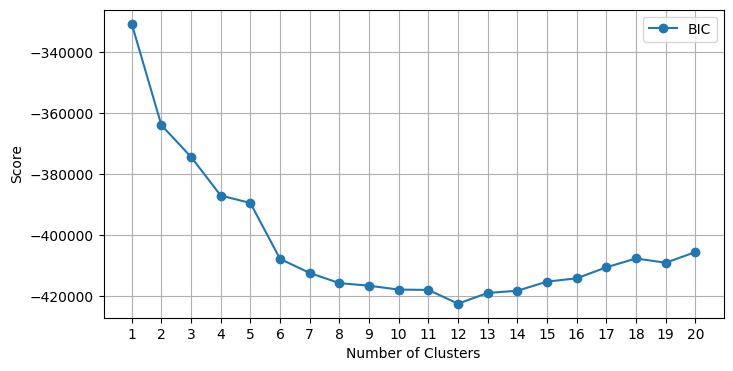

In [59]:
n_components_range = range(1, 21)
bic_scores = []

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm.fit(embeddings)
    bic_scores.append(gmm.bic(embeddings))

# Plot BIC scores for different number of clusters
plt.figure(figsize=(8, 4))
plt.plot(n_components_range, bic_scores, label='BIC', marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.xticks(np.arange(1, 21, 1))
plt.legend()
plt.grid(True)
plt.show()


From this graph we can see that some value between 10 and 15 should be good. Let's stick with 12.

Now, it's time to cluster our movement trajectories.

In [68]:
gm = GaussianMixture(n_components=12, n_init=20)
gm.fit(embeddings)

GaussianMixture(n_components=12, n_init=20)

In [69]:
# Get labels for each cluster
cluster_labels = gm.predict(embeddings)

Let's plot some representatives of each cluster to confirm visualy that clustering worked as expected.

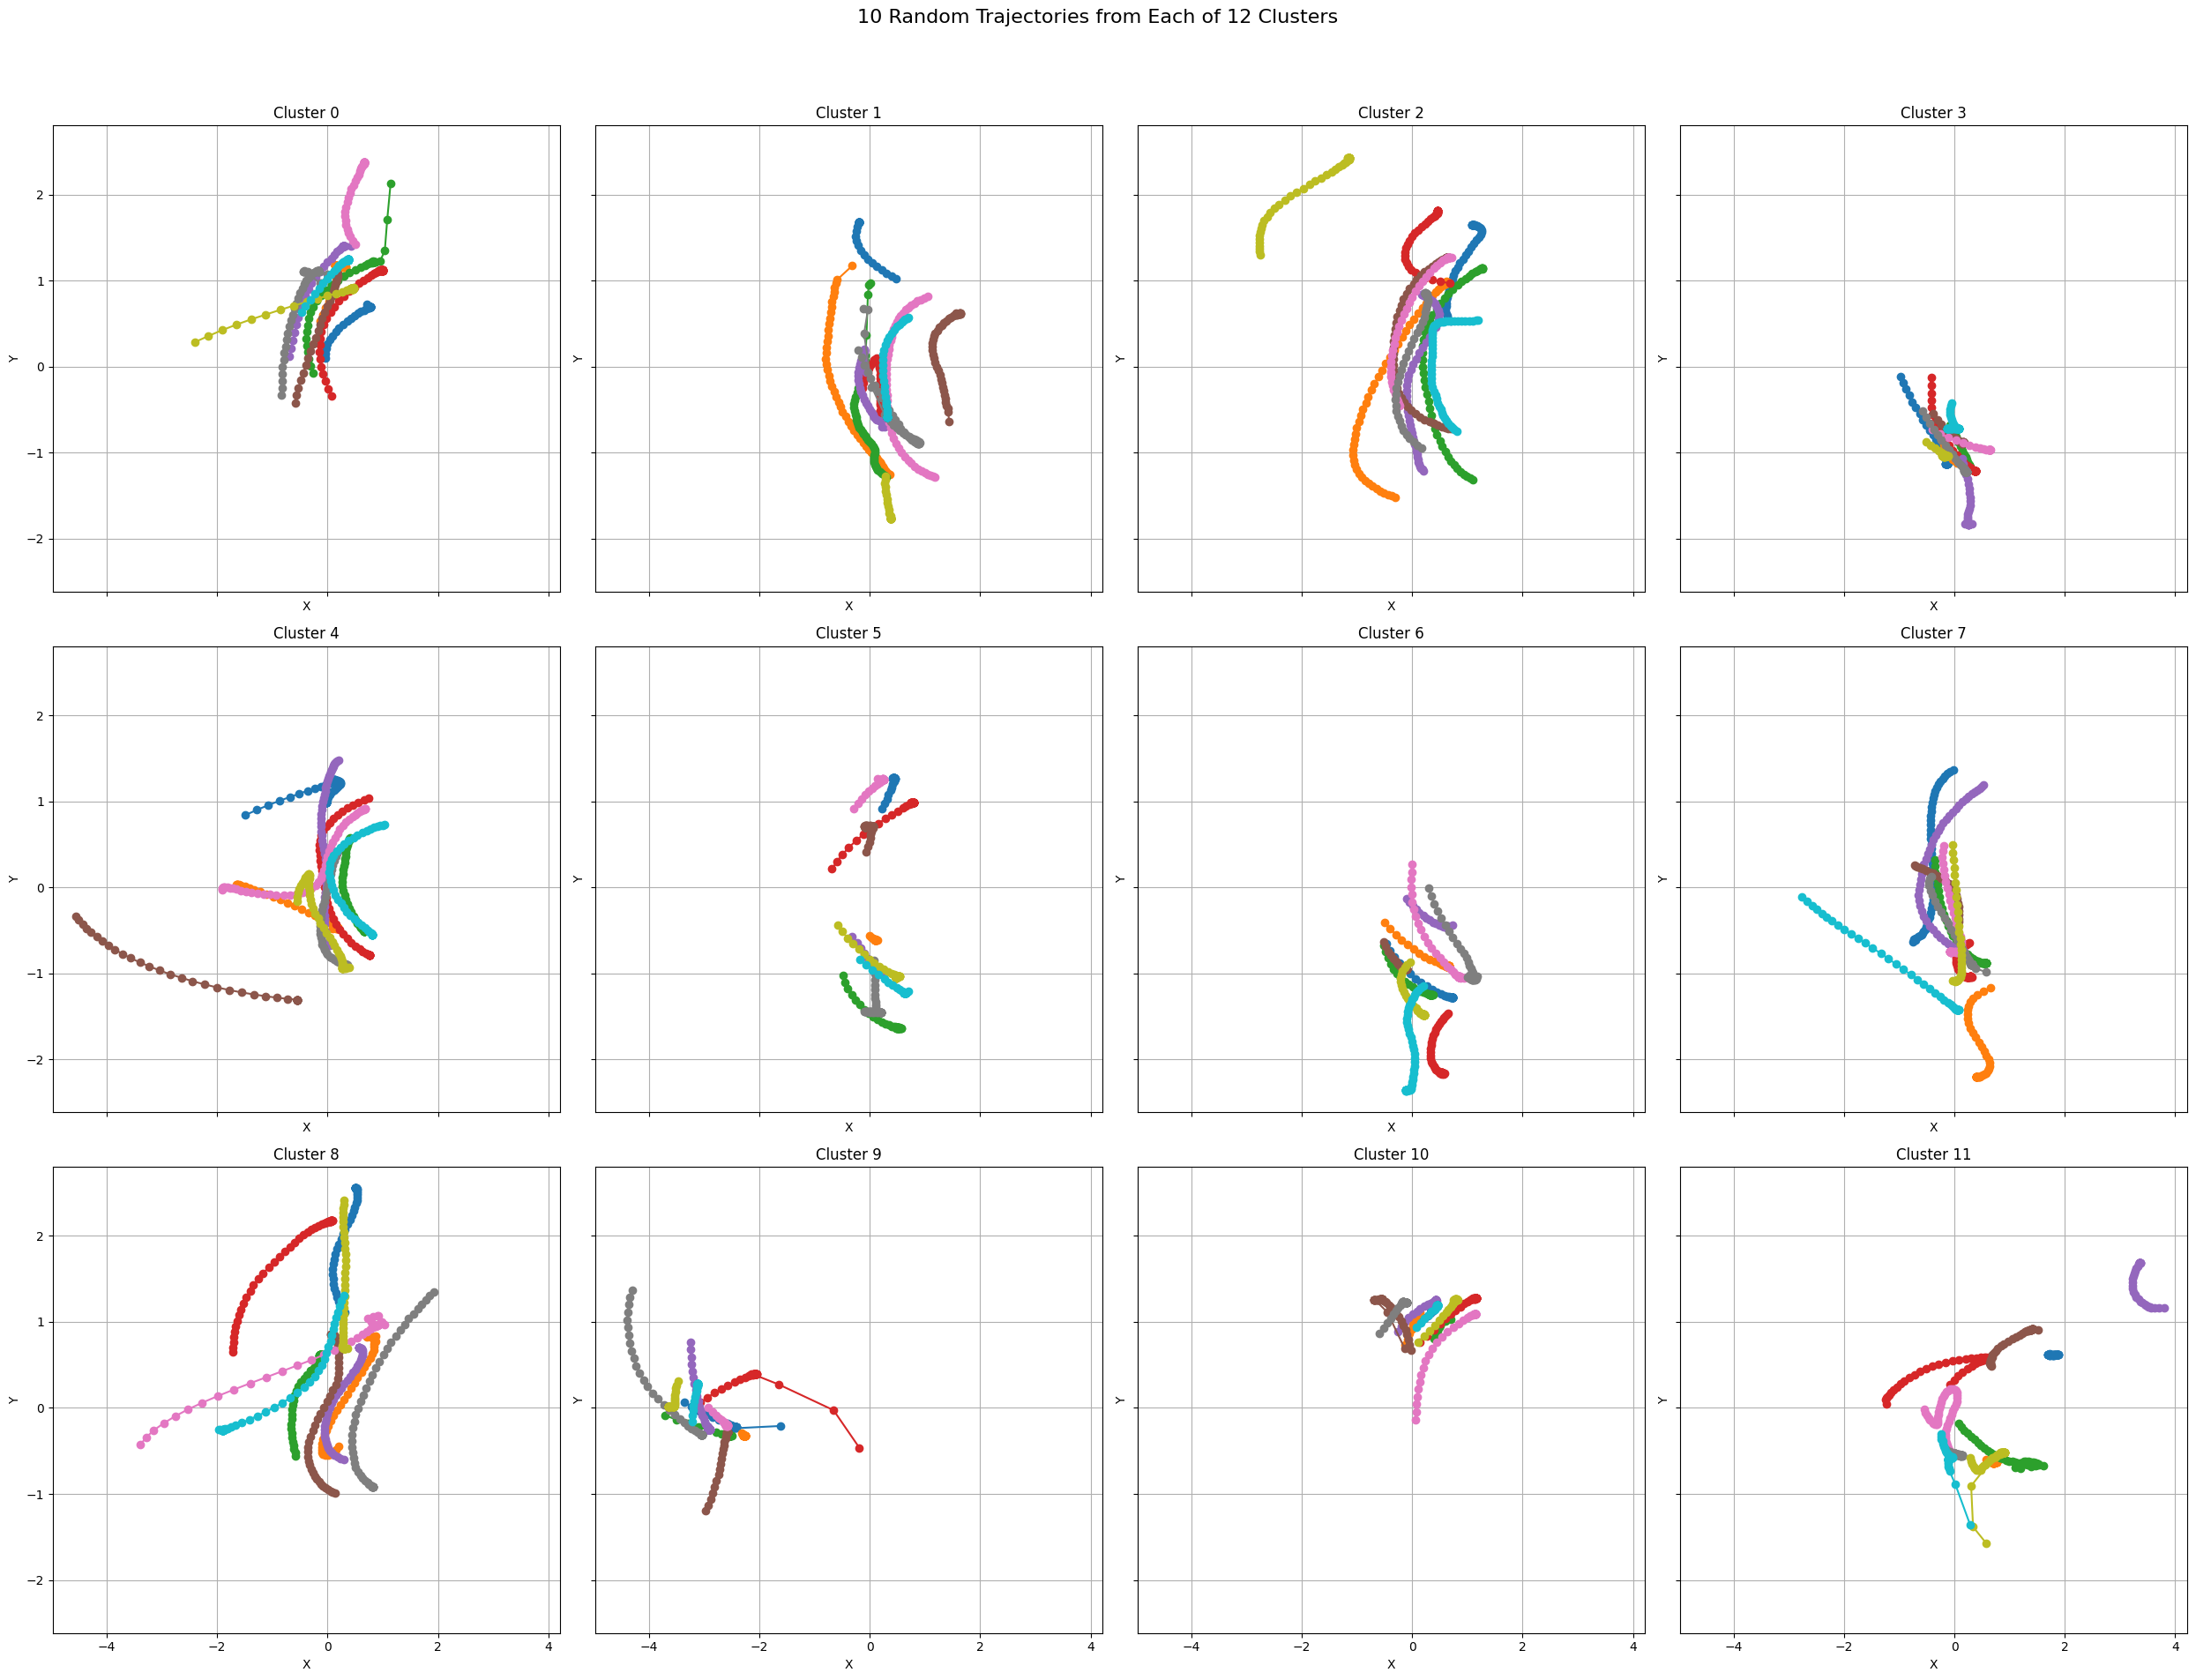

In [70]:
num_clusters = 12
trajectories_per_cluster = 10
random_seed = 42

# Set the random seed for reproducibility
random.seed(random_seed)

# Create a grid of subplots
cols = 4
rows = 3
fig, axes = plt.subplots(rows, cols, figsize=(25, 20), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten to easily iterate over axes

for cluster_num in range(num_clusters):
    ax = axes[cluster_num]
    
    # Find indices of trajectories in the current cluster
    indices_in_cluster = np.where(cluster_labels == cluster_num)[0]
    
    # Randomly sample trajectory indices
    sample_indices = random.sample(list(indices_in_cluster), trajectories_per_cluster)
    
    # Plot each sampled trajectory
    for idx in sample_indices:
        trajectory = padded_sequences[idx]
        x_coords = trajectory[:, 0]
        y_coords = trajectory[:, 1]
        
        ax.plot(x_coords, y_coords, marker='o')
    
    # Customize each subplot
    ax.set_title(f"Cluster {cluster_num}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.grid(True)

plt.suptitle(f"10 Random Trajectories from Each of {num_clusters} Clusters", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Overall, the picture looks not bad, but we can see some outliers in some clusters. Let's try to determine these outliers. We will do it by computing silhouette scores and dropping the trajectories with low scores.

In [78]:
sil_scores = silhouette_samples(embeddings, cluster_labels)
outliers_indices = np.where(sil_scores < -0.15)[0]

In [79]:
outliers_indices.shape

(122,)

We've got 122 values where silhouette score is less than 0.15. So let's remove them.

In [80]:
cluster_labels[outliers_indices] = -1

Let's plot the trajetories again.

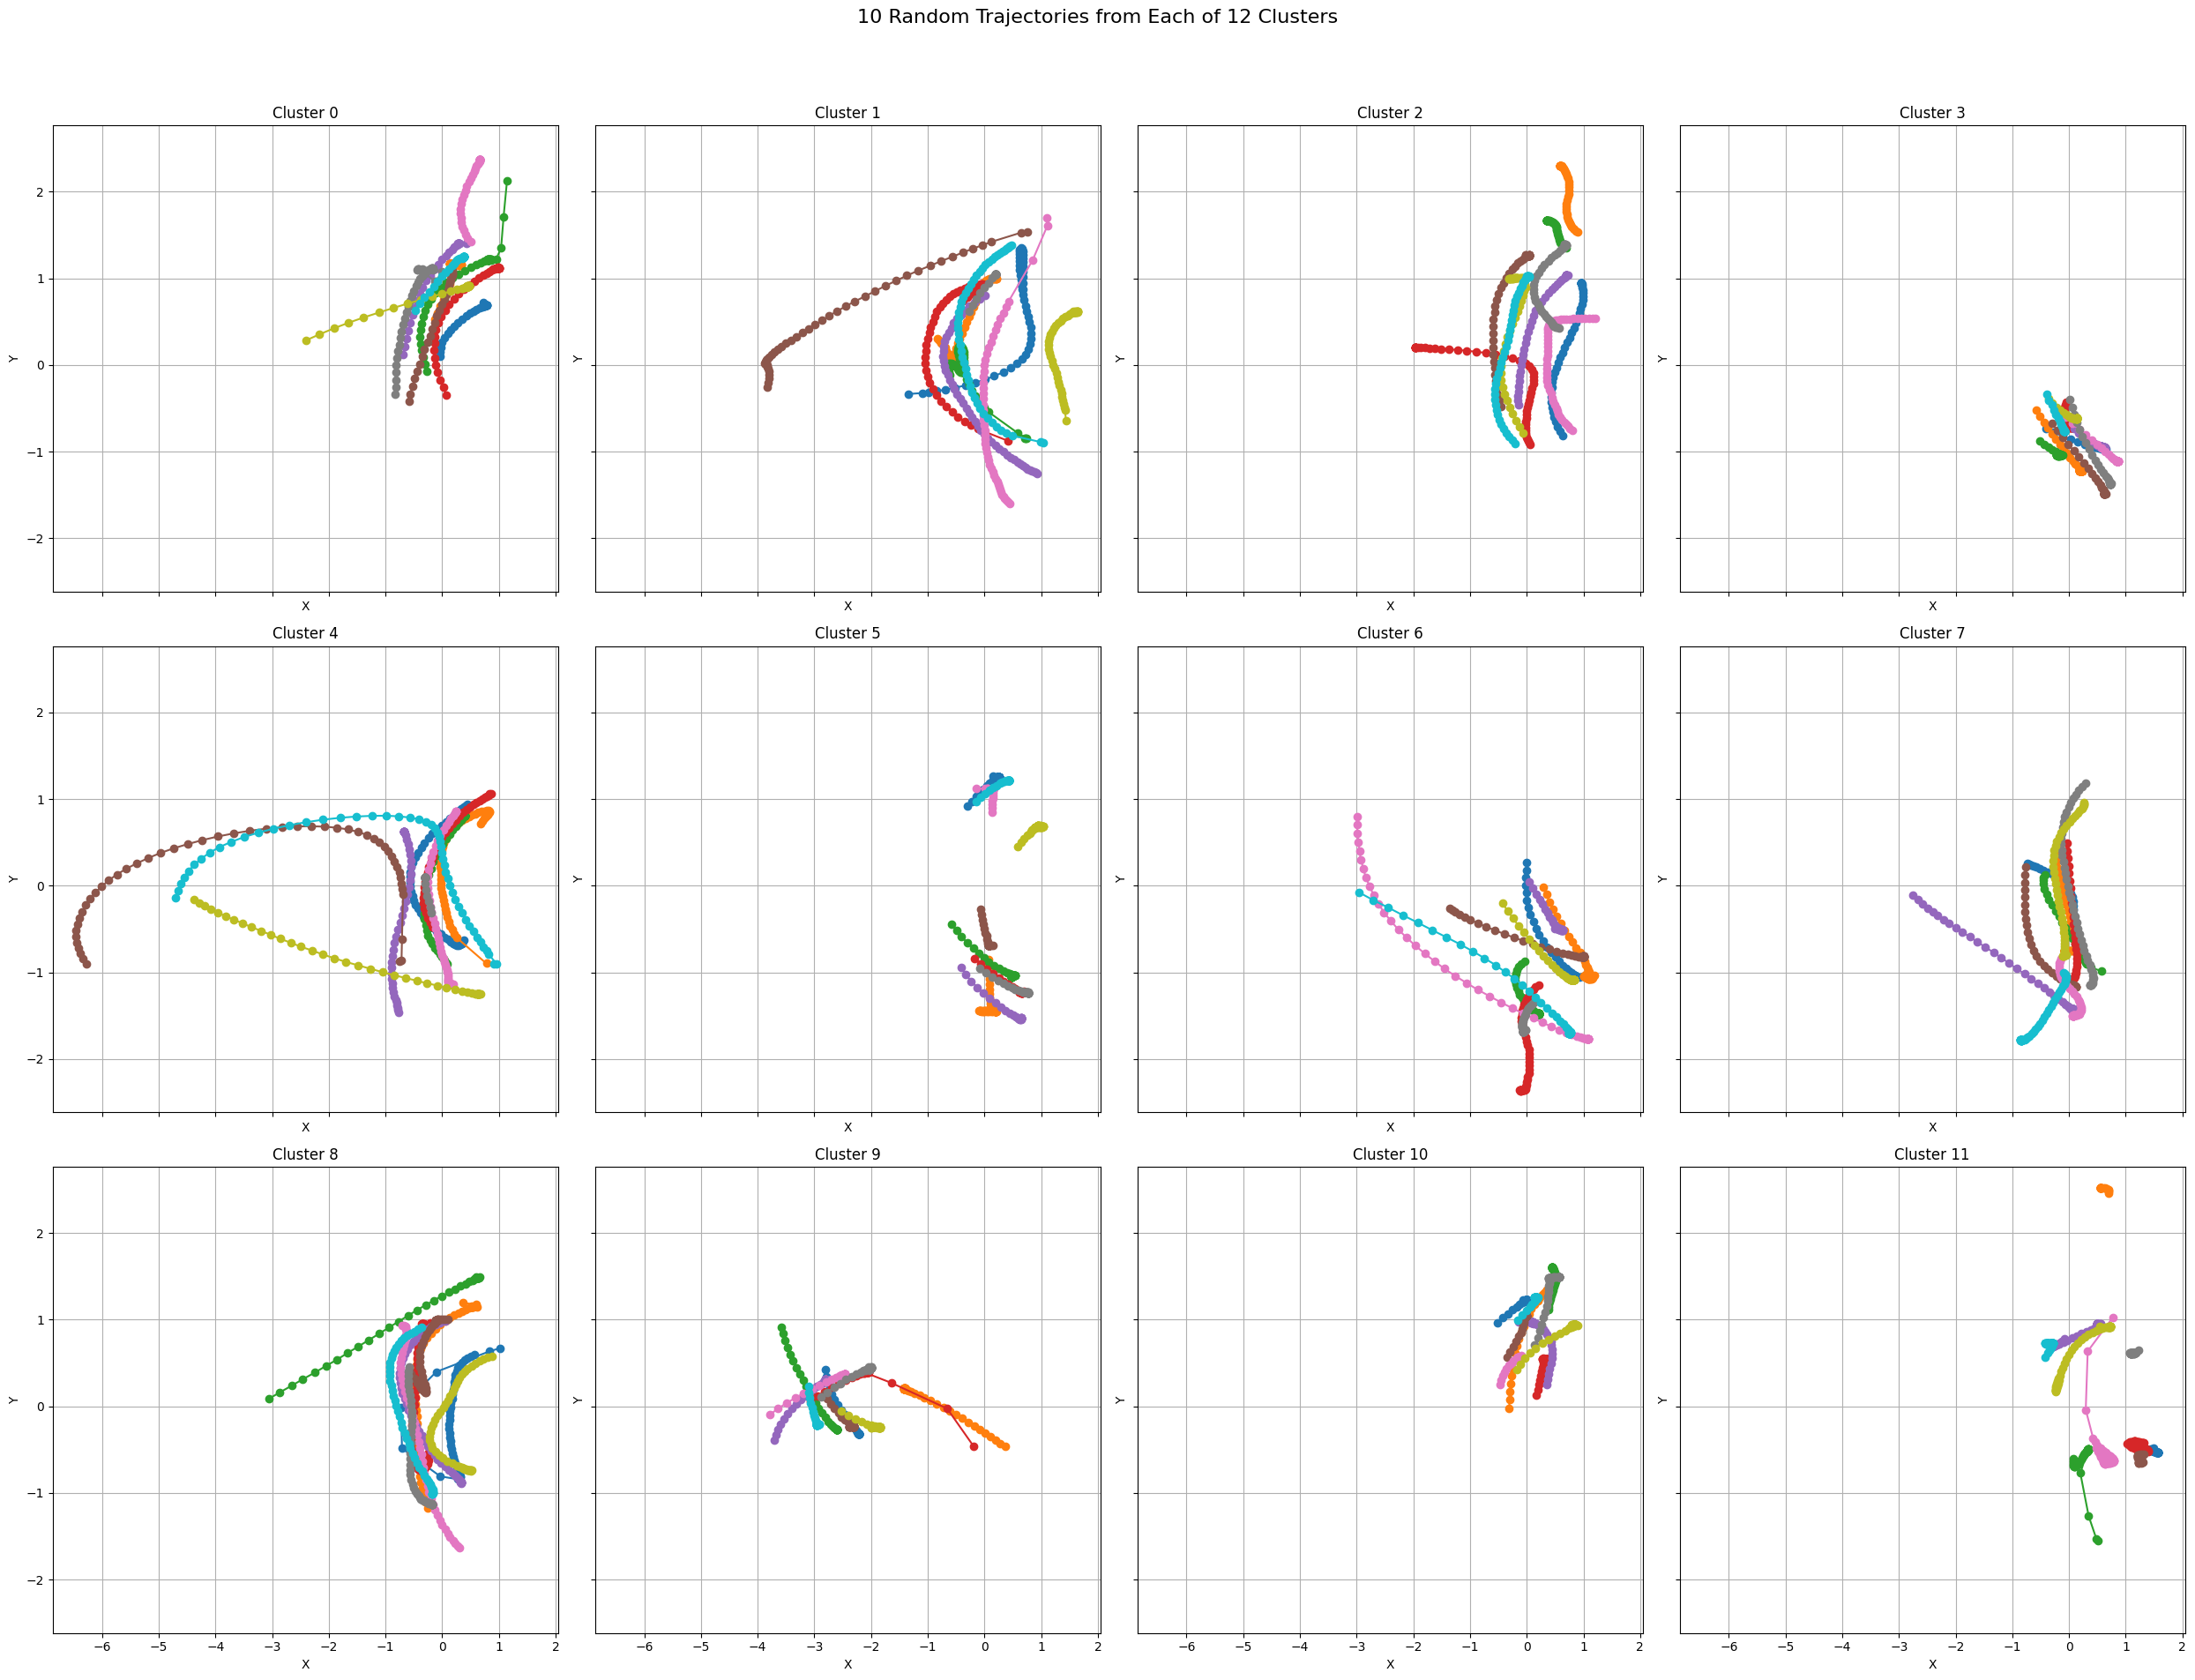

In [81]:
num_clusters = 12
trajectories_per_cluster = 10
random_seed = 42

# Set the random seed for reproducibility
random.seed(random_seed)

# Create a grid of subplots
cols = 4
rows = 3
fig, axes = plt.subplots(rows, cols, figsize=(25, 20), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten to easily iterate over axes

for cluster_num in range(num_clusters):
    ax = axes[cluster_num]
    
    # Find indices of trajectories in the current cluster
    indices_in_cluster = np.where(cluster_labels == cluster_num)[0]
    
    # Randomly sample trajectory indices
    sample_indices = random.sample(list(indices_in_cluster), trajectories_per_cluster)
    
    # Plot each sampled trajectory
    for idx in sample_indices:
        trajectory = padded_sequences[idx]
        x_coords = trajectory[:, 0]
        y_coords = trajectory[:, 1]
        
        ax.plot(x_coords, y_coords, marker='o')
    
    # Customize each subplot
    ax.set_title(f"Cluster {cluster_num}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.grid(True)

plt.suptitle(f"10 Random Trajectories from Each of {num_clusters} Clusters", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

To get even better look of clusters, let's plot all the trajectories for each cluster with the mean trajectory within cluster.

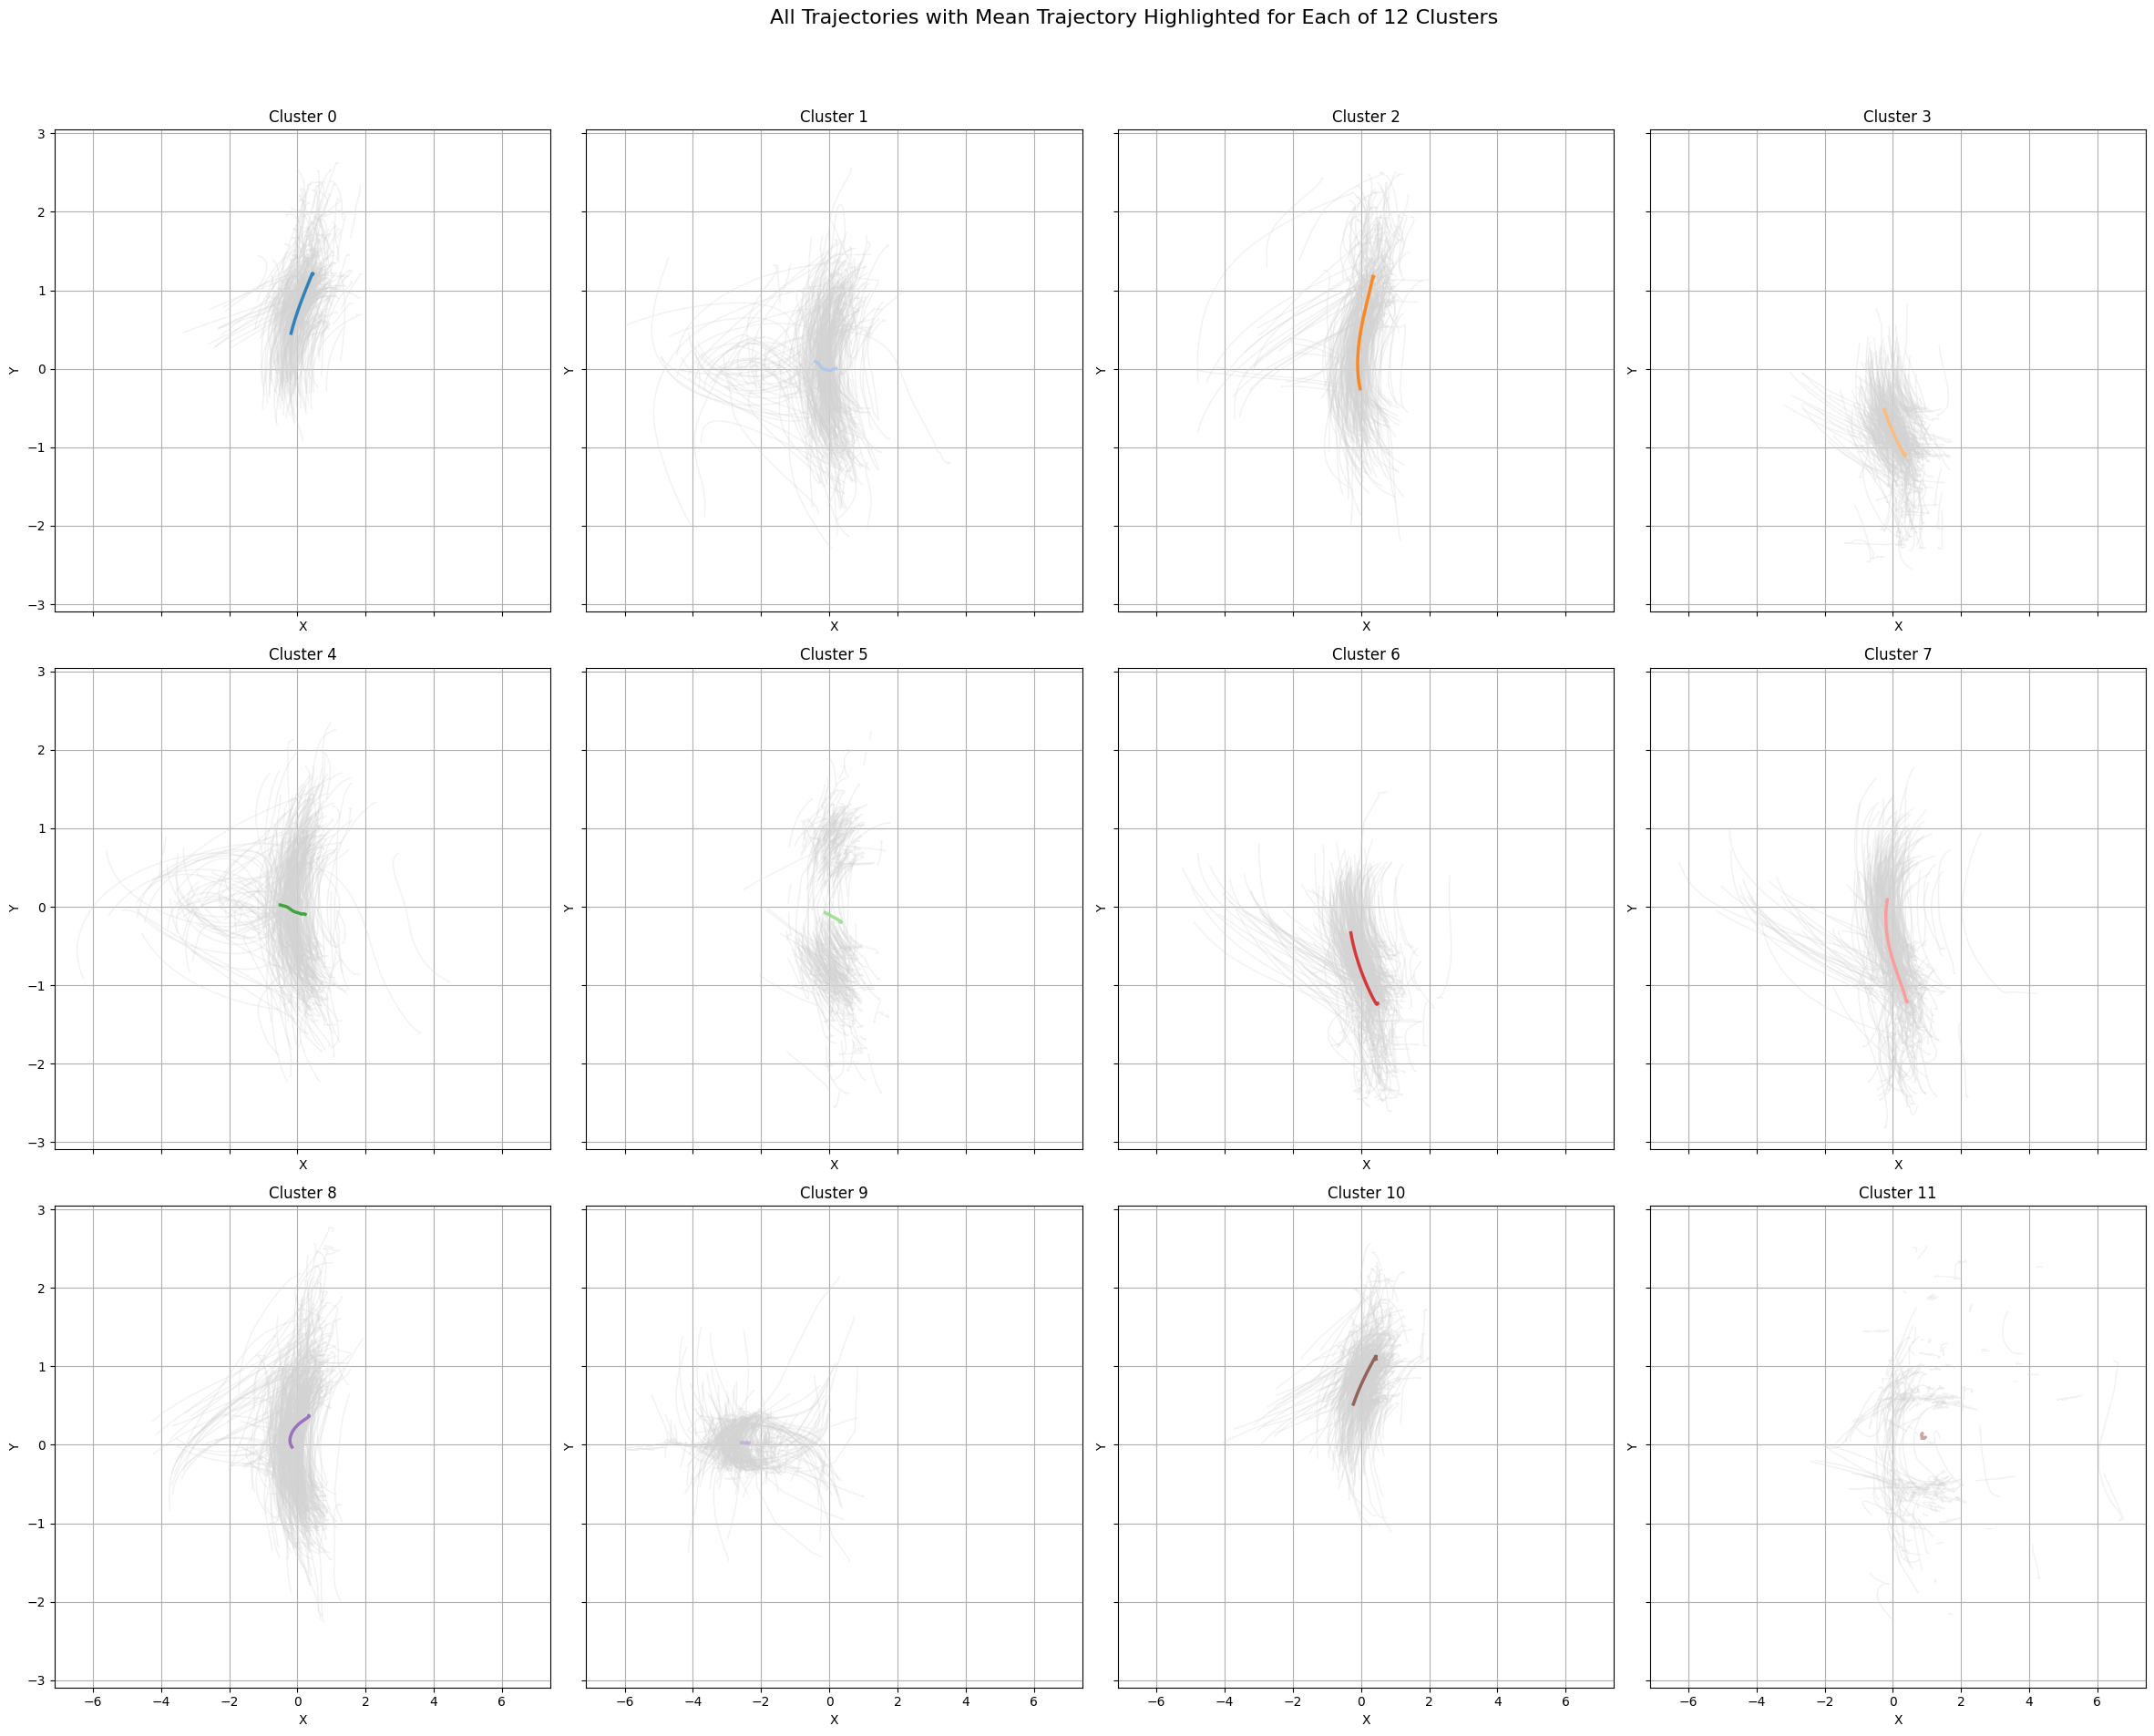

In [85]:
num_clusters = 12
random_seed = 42

random.seed(random_seed)

# Create a grid of subplots
cols = 4
rows = 3
fig, axes = plt.subplots(rows, cols, figsize=(25, 20), sharex=True, sharey=True)
axes = axes.flatten()

# Define a colormap for mean trajectories
cmap = plt.get_cmap('tab20')

for cluster_num in range(num_clusters):
    ax = axes[cluster_num]
    
    # Find indices of trajectories in the current cluster
    indices_in_cluster = np.where(cluster_labels == cluster_num)[0]
    
    # Plot all trajectories in dim color
    for idx in indices_in_cluster:
        trajectory = padded_sequences[idx]
        x_coords = trajectory[:, 0]
        y_coords = trajectory[:, 1]
        
        ax.plot(x_coords, y_coords, color='lightgray', alpha=0.3, linewidth=1)
    
    # Compute the mean trajectory
    mean_trajectory = np.mean(padded_sequences[indices_in_cluster], axis=0)
    mean_x = mean_trajectory[:, 0]
    mean_y = mean_trajectory[:, 1]
    
    # Assign a unique color for the mean trajectory
    mean_color = cmap(cluster_num % cmap.N)
    
    # Plot the mean trajectory
    ax.plot(mean_x, mean_y, color=mean_color, alpha=0.9, linewidth=2.5, label='Mean Trajectory')
    
    # Customize each subplot
    ax.set_title(f"Cluster {cluster_num}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.grid(True)

plt.suptitle(f"All Trajectories with Mean Trajectory Highlighted for Each of {num_clusters} Clusters", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 0.95, 0.95]) 
plt.show()

